In [2]:
import pandas as pd
import numpy as np

import sys
import os

# Get the current working directory (where the notebook is running)
notebook_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now you can import your module
from utils import factor_model_solution, factor_goodness_of_fit_test

*This notebook investigates if factor analysis is still able to extract the correct pathways, if k is not predetermined. Instead k will be choosen using the goodness of fit test.*

# More factors $k$ than pathways

We'll be using the DICER1 corr rankings.

In [3]:
df_gene_effect = pd.read_csv("preprocessed_data/20Q4v2_Achilles_gene_effect.csv")
df_correlations = {
    "DICER1": pd.read_csv("preprocessed_data/corr_DICER1_preprocessed.csv", delimiter=";")
}

# Number of genes to include from each corr file taking top X // 2 and bottom X // 2.
# Note that the same gene may be selected in both corr files. (But will only appear once in the final selected_genes list.)
number_of_genes = 10
assert number_of_genes % 2 == 0, "number_of_genes should be an even number."

selected_columns = pd.concat(
    [df_correlations["DICER1"]["gene_evaluated"][:number_of_genes // 2], 
     df_correlations["DICER1"]["gene_evaluated"][-number_of_genes // 2:]]
    ).to_list()
selected_columns = set(selected_columns)

# number_of_genes multiplied by how many corr files we have.
number_of_duplicates = (number_of_genes * len(df_correlations)) - len(selected_columns) 
if number_of_duplicates > 0:
    print(f"Warning: {number_of_duplicates} duplicates were removed.")

# Extract gene names according to the format of gene_effect dataset.
selected_columns_gene_effect_format = [column for column in df_gene_effect.columns if column.split(" ")[0] in selected_columns]

# Rough automatic check for whether we found all corresponding columns in gene_effect dataset that we've selected.
assert len(selected_columns) == len(selected_columns_gene_effect_format)

# Extract columns from gene_effect dataset.
X = df_gene_effect[selected_columns_gene_effect_format].dropna() # Is dropping rows with na a good idea? Maybe use mean value instead?
X = X.to_numpy()
num_dropped_rows = df_gene_effect.shape[0] - X.shape[0]
if num_dropped_rows > 0:
    print(f"Warning: {num_dropped_rows} rows contained at least 1 NA and was dropped.")
X.shape

(808, 10)

In [4]:
print("Goodness of Fit tests on data with shape", X.shape)
print("p-value for k = 1:", factor_goodness_of_fit_test(X, k = 1))

for i in range(1, X.shape[1]):
    pvalue = factor_goodness_of_fit_test(X, k = i)
    if pvalue >= 0.05:
        print("Found sufficient factors:")
        print("FAC| PVAL")
        print(f" {i} | {pvalue.round(4)}")
        print(f"({i - 1} | {factor_goodness_of_fit_test(X, k = i - 1).round(4)})")

        # Automatically set k
        k = i
        
        break

Goodness of Fit tests on data with shape (808, 10)
p-value for k = 1: 7.640647361670192e-08
Found sufficient factors:
FAC| PVAL
 3 | 0.405
(2 | 0.0256)


In [5]:
_, lambda_hat = factor_model_solution(X, k = k)

# Adjust precision and disable scientific notation for better readability
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
lambda_hat

array([[ 0.352, -0.198,  0.238],
       [ 1.   ,  0.019, -0.   ],
       [ 0.017,  0.035, -0.155],
       [ 0.306, -0.419,  0.61 ],
       [ 0.208, -0.191,  0.304],
       [ 0.047, -0.043,  0.135],
       [ 0.046,  0.167, -0.097],
       [ 0.022, -0.025,  0.144],
       [ 0.375, -0.927, -0.   ],
       [ 0.004,  0.025,  0.196]])

In [6]:
loadings = lambda_hat.T # Extract loadings as a list

# Extract gene names (everything before the space)
genes = [column.split(" ")[0] for column in selected_columns_gene_effect_format]

# Set up the structure of the dataframe
data_frame_structure = {
    'gene_evaluated': genes
}
for idx, loading_vector in enumerate(loadings):
    data_frame_structure["loadings" + str(idx)] = loading_vector

# Create a DataFrame from genes and values
df_values = pd.DataFrame(data_frame_structure)

# Merge with df_correlations on 'gene'
merged_df = (df_values
             .merge(df_correlations["DICER1"][['gene_evaluated', 'is_on_pathway']], on='gene_evaluated', how='left')
             .rename(columns={"is_on_pathway": "is_on_pathway_DICER1"})
             )

In [7]:
# Make the table more readable
pd.set_option('display.float_format', lambda x: '%.4f' % x)

merged_df.sort_values("loadings0", ascending=False)

,gene_evaluated,loadings0,loadings1,loadings2,is_on_pathway_DICER1
1,ANKRD52,0.9998,0.0188,-0.0000,1
8,XPO5,0.3747,-0.9271,-0.0000,1
0,AGO2,0.3517,-0.1981,0.2377,1
3,DICER1,0.3063,-0.4194,0.6095,1
4,DROSHA,0.2078,-0.1907,0.3038,1
5,HYOU1,0.0472,-0.0428,0.1347,0
6,ORMDL2,0.0463,0.1670,-0.0974,0
7,PCDHB16,0.0218,-0.0251,0.1435,0
2,BTG1,0.0168,0.0346,-0.1555,0
9,ZSCAN22,0.0044,0.0255,0.1957,0


We probably find the correct pathway here in the first factor. However note that XPO5 has a loading of -0.9 on the second factor. Preferably, this loading was 0.

Text(0.5, 0, '1st Factor')

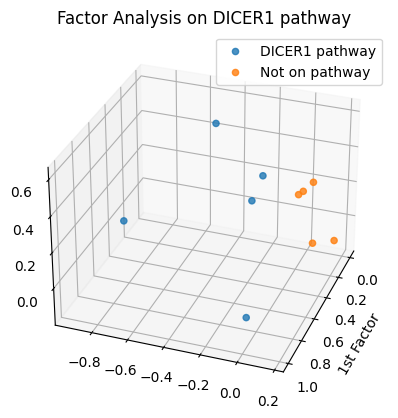

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for category_num, label in [(1, "DICER1 pathway"), (0, "Not on pathway")]:
    subset = merged_df[merged_df['is_on_pathway_DICER1'] == category_num]
    ax.scatter(subset['loadings0'], subset['loadings1'], subset['loadings2'], label=label, alpha=0.8)

ax.view_init(azim=20)
plt.title("Factor Analysis on DICER1 pathway")
plt.legend()
plt.xlabel("1st Factor")

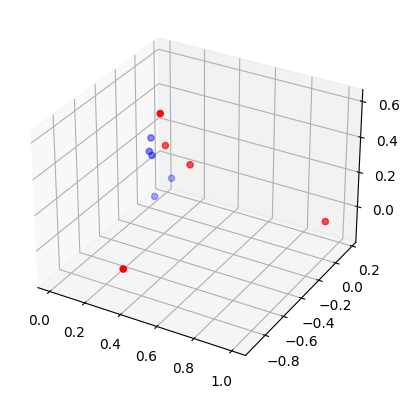

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = ['r' if on_path else 'b' for on_path in merged_df['is_on_pathway_DICER1']]
ax.scatter(merged_df['loadings0'], merged_df['loadings1'], merged_df['loadings2'], c=color)
plt.show()

cycle:	1	theta:	89.0909090909091	pair:	(0, 1)	objective:	3.087868841545066
cycle:	1	theta:	88.18181818181819	pair:	(0, 2)	objective:	3.0927663277645276
cycle:	1	theta:	0.0	pair:	(1, 2)	objective:	3.0927663277645276
cycle:	2	theta:	89.0909090909091	pair:	(0, 1)	objective:	3.092881301095134
cycle:	2	theta:	90.0	pair:	(0, 2)	objective:	3.0928813010951344
cycle:	2	theta:	0.0	pair:	(1, 2)	objective:	3.0928813010951344
cycle:	3	theta:	90.0	pair:	(0, 1)	objective:	3.092881301095135
cycle:	3	theta:	0.0	pair:	(0, 2)	objective:	3.092881301095135
cycle:	3	theta:	0.0	pair:	(1, 2)	objective:	3.092881301095135
Phi has converged; Algorithm ending early.


Text(0.5, 0, '1st Factor')

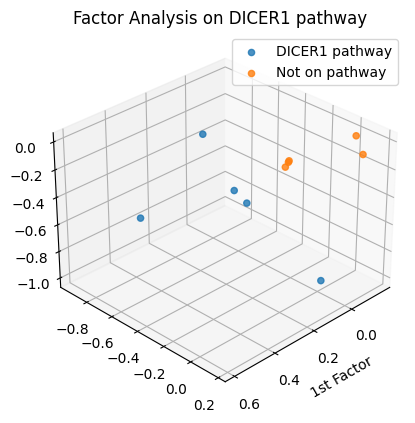

In [23]:
from utils import varimax

data_numpy = merged_df[['loadings0', 'loadings1', 'loadings2']].to_numpy()

varimax(data_numpy, verbose=True)

rotated_df = merged_df.copy()
rotated_df['loadings0'] = data_numpy[:,0]
rotated_df['loadings1'] = data_numpy[:,1]
rotated_df['loadings2'] = data_numpy[:,2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for category_num, label in [(1, "DICER1 pathway"), (0, "Not on pathway")]:
    subset = rotated_df[rotated_df['is_on_pathway_DICER1'] == category_num]
    ax.scatter(subset['loadings0'], subset['loadings1'], subset['loadings2'], label=label, alpha=0.8)

ax.view_init(azim=45)
plt.title("Factor Analysis on DICER1 pathway")
plt.legend()
plt.xlabel("1st Factor")

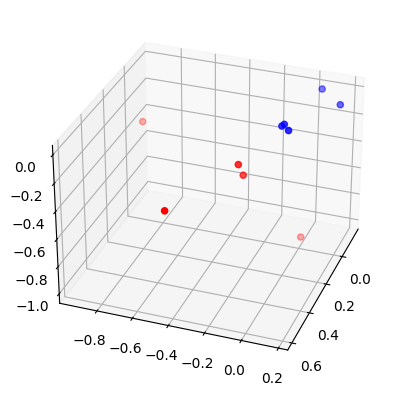

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = ['r' if on_path else 'b' for on_path in merged_df['is_on_pathway_DICER1']]
ax.scatter(rotated_df['loadings0'], rotated_df['loadings1'], rotated_df['loadings2'], c=color)
ax.view_init(azim=20) # Adjust viewing angle
plt.show()

In [28]:
rotated_df.sort_values(by='loadings2')

,gene_evaluated,loadings0,loadings1,loadings2,is_on_pathway_DICER1
1,ANKRD52,-0.0158,0.0030,-0.9999,1
8,XPO5,-0.0353,-0.9325,-0.3594,1
0,AGO2,0.2256,-0.2111,-0.3521,1
3,DICER1,0.5909,-0.4434,-0.3090,1
4,DROSHA,0.2942,-0.2036,-0.2095,1
5,HYOU1,0.1325,-0.0478,-0.0487,0
6,ORMDL2,-0.0929,0.1692,-0.0474,0
7,PCDHB16,0.1423,-0.0300,-0.0236,0
2,BTG1,-0.1546,0.0392,-0.0149,0
9,ZSCAN22,0.1963,0.0192,-0.0079,0


XPO5 still loaded heavily on another factor.